In [1]:
# Essentials for training and env

# Car env
from env_06 import RacingCar, PATHS, TRACKS_FOLDER, TRACKS, MAX_SPEED

# For neural networks
import torch 
import torch.nn as nn 
import torch.functional as F
import torch.optim as optim

# For math computations
import numpy as np

# For random
import random as rd

# For envs
import gymnasium

# For time limit
import time

# Structure to save transitions 
from collections import namedtuple , deque
Transition = namedtuple("Transition",["state","action","next_state","reward"])

# For plots
import matplotlib.pyplot as plt
#%matplotlib inline
from IPython import display

# For saving files
from datetime import datetime
import json
import os

# for model vizualisation 
from torchsummary import summary


class ReplayMemory():
    def __init__(self,maxlen : int):
        self.memory_ = deque(maxlen=maxlen)

    def push(self,x : Transition):
        """Add a new transition to the memory"""
        self.memory_.append(x)

    def sample(self,batch_size : int) -> list[Transition]:
        """Sample a subset of size batch_size uniformly among the subsets of size batch_size of the memory. 
           We assume that such subset exists.
        """
        return rd.sample(self.memory_,batch_size)
    
    def clear(self):
        """Clear the memory"""
        return self.memory_.clear()
    
    def __len__(self):
        return len(self.memory_)

class DQN(nn.Module):
    def __init__(self,layer_size,state_size,action_n):
        super(DQN,self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,layer_size),
            nn.ReLU(),

            nn.Linear(layer_size,action_n),
        )

    def forward(self,x):
        return self.network(x)
    
    def save(self,filename : str = None):
        """Save model's parameters in the given file"""
        if (filename == None):
            filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        torch.save(self.state_dict(),filename)

    def load(self,filename : str):
        """Load parameters stored in the given file"""
        self.load_state_dict(torch.load(filename, weights_only=True))

class Env():
    def __init__(self):
        self.done = False

        # Underlying environment
        self.env = RacingCar()
        self.state_gym,_ = self.env.reset(TRACKS[0])
        self.n_action = self.env.nb_state

        # Current model estimating the Q-function
        self.model = DQN(400,8,self.n_action)

        # Transition history
        self.memory = ReplayMemory(10000)

        # To normalize the Q-function later, in the reward function
        self.discount_factor = 0.9

        # Number of tracks allowed
        self.track_for_training = int(len(TRACKS)*0.8)

    def state(self):
        """A state is either a batch of size 1 or None"""
        if (self.state_gym == None or self.done) :
            return None
        else :
            arr = np.array(self.env.get_state())
            arr = arr / max(MAX_SPEED, self.env.max_dist_wall) #To normalize the array
            return torch.tensor([arr],dtype=torch.float)

    def show_state(self):
        """plot the current trajectory"""
        self.env.render(show_trajectory=True)

    def reset(self):
        """Reset the environment"""
        rd_track = rd.randint(0, self.track_for_training -1)
        self.state_gym , _ = self.env.reset(TRACKS[rd_track])
        self.done = False
       
    def step(self,action : torch.tensor) :
        """Move from the current state to the next state thanks to the action, observing a reward"""
        if (self.done):
            raise(ValueError("Trying to move from a final state"))

        prev_state = self.state()

        # Do the step and update the new gym state
        acc, turn = self.env.int_to_action(action.item())
        if np.absolute(turn) > self.env.max_turn:
            print(action.item(), (acc, turn))
            
        self.state_gym,reward,terminated,truncated,_ = self.env.step(action.item())
        self.done = terminated or truncated

        next_state = self.state()

        reward_normalizer = self.env.reward_max
        qtable_normalizer = 1/(1-self.discount_factor)
        # We normalize the reward
        reward = torch.tensor(reward/(reward_normalizer*qtable_normalizer), dtype=torch.float).reshape((1,1))
        action = torch.tensor(action.item()).reshape((1,1))

        transition = Transition(prev_state, action, next_state , reward)
        return transition
    
    def policy(self):
        """Predict the best action according to our current model"""
        if (self.done):
            raise(ValueError("Trying to predict a move from a final state"))
        return self.model(self.state()).max(1).indices.reshape((1,1))
    
    def random_action(self) -> torch.tensor :
        """Select a random action"""
        if (self.done):
            raise(ValueError("Trying to sample a move from a final state"))
        action = rd.randint(0,self.n_action-1)
        return torch.tensor(action).reshape((1,1))

def optimize(env : Env,optimizer,criterion,batch_size,discount_factor):
    """Optimize the model according to batch_size random transitions observed in the past"""
    # We optimize only if have >= batch_size transition in our replay buffer
    if (len(env.memory) < batch_size) :
        return 

    # A list of batch_size transtions
    transition = env.memory.sample(batch_size)

    # A tuple with four coordinates : 
    # state -> a batch of size batch_size of states 
    # action -> a batch of size batch_size of actions
    # reward -> a batch of size batch_size of rewards
    # next_state -> a batch of size batch_size of the next states
    batch = Transition(*zip(*transition))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Batch of size batch_size of the Qvalue predicted by our current model, for the state and action of a transtion
    predicted = env.model(state_batch).gather(1,action_batch)

    next_state_value = torch.zeros((batch_size,1))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool )
    if non_final_mask.any():
        non_final_next_state = torch.cat([s for s in batch.next_state if s is not None])
        with torch.no_grad():
            next_state_value[non_final_mask] = env.model(non_final_next_state).max(1).values.unsqueeze(1)

    expected = reward_batch + (discount_factor * next_state_value)

    optimizer.zero_grad()
    loss = criterion(predicted,expected)
    loss.backward()
    # We bound the gradient by 100
    torch.nn.utils.clip_grad_value_(env.model.parameters(), 100)
    optimizer.step()

def measure_policy_time(env) :
    """Measure the time needed by the model to predict one action"""
    env.reset()
    time_deb = time.perf_counter()
    env.policy()
    return time.perf_counter() - time_deb

def measure_model_size(env):
    """Count the number of parameters of the underlying neural network"""
    return sum(p.numel() for p in env.model.parameters())

def evaluate_model_reward(env):
    """Compute the average reward obtained by the model on the tracks he has never seen before"""
    sum = 0
    max_step = 300
    for i in range(env.track_for_training,len(TRACKS)) :
        env.state_gym , _ = env.env.reset(TRACKS[i])
        env.done = False
        i = 0
        while(i < max_step and not(env.done)) :
            i+=1
            transition = env.step( env.policy() )
            sum += transition.reward.item()
    return sum/( len(TRACKS) - env.track_for_training)

def training(lr=1e-4,epsilon_decay=30.,batch_size = 40,time_bound = 60*(1),track_budget=int(0.8*len(TRACKS))):
    """
    We train a model initialised with random parameters using a Deep Q-Learning algorithm.
    We allow to change 4 hyperparameters : 
    - lr : the learning rate 
    - epsilon_decay : measure the amount of random choices the model will do during the training
    - time_bound : the time budget allowed for the training
    - track_budget : the number tracks allowed for the training
    We output a dictionnary containing informations on the training.
    """
    env = Env()
    filename =  "saved_model/"  + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    # Create the folder "saved_model" where the model's parameters will be saved
    if not os.path.exists("saved_model"):
        os.makedirs("saved_model")

    # track budget for training
    env.track_for_training = track_budget

    # Hyperparameters
    #batch_size = 40
    epochs = 5000
    max_episode_duration = 1000 * 1/env.env.time
    epsilon_max = 1
    epsilon_min = 0.01
    #epsilon_decay = 30.
    #lr = 1e-4
    discount_factor = 0.9
    env.discount_factor = discount_factor
    optimizer = optim.AdamW(env.model.parameters(), lr=lr, amsgrad=True)
    criterion = nn.SmoothL1Loss()

    env.memory.clear()

    reward_history = []
    reward_time = []
    volatility_history = []
    volatility_time = []

    #time_bound = 60*(1)
    time_start = time.perf_counter()
    i = 0
    while ( (time.perf_counter() - time_start <= time_bound)  ):
        i += 1
        env.reset()
        epsilon = epsilon_min + (epsilon_max-epsilon_min)*np.exp(-i/epsilon_decay)
        it_counter = 0
        reward = 0
        while(not(env.done) and it_counter < max_episode_duration):
            it_counter += 1
            # Chose an action
            if (rd.random() <= epsilon):
                action = env.random_action()
            else:
                with torch.no_grad() :
                    action = env.policy()
            # Apply the transition and save it in the memory
            transition = env.step(action)
            reward += (transition.reward).item()
            env.memory.push(transition)
            # Optimize the model according to batch_size random transitions
            optimize(env,optimizer,criterion,batch_size,discount_factor)
    
        # Stats about the training
        second = (int(time.perf_counter() - time_start)) % 60
        minute = (int(time.perf_counter() - time_start)) //60
        window_len = 30
        iteration_time = time.perf_counter() - time_start
        # We save the model every 5 minutes
        if (minute%5 == 0 and minute > 3) :
            env.model.save(filename)
        reward_time.append( iteration_time  )
        volatility_time.append(iteration_time)
        reward_history.append(reward)
        last_window = reward_history[-window_len:]
        volatility_history.append(np.std(last_window))
    
    res = {}
    res["training_time"] = time_bound
    res["track_number"] = track_budget
    res["global_volatility"] = np.std(reward_history)
    res["model_size"] = measure_model_size(env)
    res["policy_time"] = measure_policy_time(env)
    res["policy_score"] = evaluate_model_reward(env)
    res["reward_history"] = reward_history
    res["reward_time"] = reward_time 
    res["volatility_history"] = volatility_history
    res["volatility_time"] = volatility_time 
    res["DQN_model_param"] = filename
    res["DQN_model_param_is_saved"] = False
    res["learning rate"] = lr 
    res["batch size"] = batch_size
    res["epsilon decay"] = epsilon_decay

    # we save the model if we trained it for more that 3 minutes
    minute = (int(time.perf_counter() - time_start)) //60
    if (minute > 3) :
         env.model.save(filename)
         res["DQN_model_param_is_saved"] = True
    
    return res


def playing(env):
    """Observe how the model behave on all tracks"""
    sum = 0
    max_step = 300
    mini = 0
    for i in range(mini,len(TRACKS)) :
        env.state_gym , _ = env.env.reset(TRACKS[i])
        env.done = False
        j = 0
        while(j < max_step and not(env.done)) :
            j+=1
            transition = env.step( env.policy() )
            sum += transition.reward.item()
            env.show_state()
    return sum/( len(TRACKS) - mini)



def part1_data():
    """Compute the data to compare Deep Q-Learning with Genetic algorithms"""
    training_times_min = [10,40,60]
    training_times_sec = [60*i for i in training_times_min]
    track_limit = [8,40, int(0.8*len(TRACKS)) ]
    # We check if we have enough tracks to do the training
    if (len(TRACKS) < max(track_limit)) :
        raise(ValueError("not enough tracks"))
    # Create the folder associated with the training
    folder_name =  "run_part1_"+ datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    os.makedirs(folder_name)
    # Train the model
    for time_bound in training_times_sec :
        for track_budget in track_limit :
            json_object = json.dumps( training(time_bound=time_bound,track_budget=track_budget))
            with open(folder_name + "/" + str(time_bound)+"_"+str(track_budget)+".json","w") as f :
                f.write(json_object)

def part2_data():
    """Compute the data to evaluate the dependence of the training on Hyperparameters (learning rate, batch size and epsilon decay)"""
    training_time = 30*(60)
    lr_l = [1e-2,1e-3,1e-4,1e-5,1e-6]
    batch_size_l = [10,30,50,80,120]
    epsilon_decay_l = [10.,30.,50.,120.,200.]
    track_budget = int(0.8*len(TRACKS))

    # Create the folder associated with the training
    folder_name =  "run_part2_"+ datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    os.makedirs(folder_name)

    # For learning rate
    for lr in lr_l :
        json_object = json.dumps( training(lr=lr, track_budget=track_budget , time_bound=training_time ))
        with open(folder_name + "/" + "lr"+"_"+str(lr)+".json","w") as f :
            f.write(json_object)

     # For batch size
    for batch_size in batch_size_l :
        json_object = json.dumps( training(batch_size=batch_size, track_budget=track_budget , time_bound=training_time ))
        with open(folder_name + "/" + "batch_size"+"_"+str(batch_size)+".json","w") as f :
            f.write(json_object)

    # For epsilon decay
    for epsilon_decay in epsilon_decay_l :
        json_object = json.dumps( training(epsilon_decay=epsilon_decay, track_budget=track_budget , time_bound=training_time ))
        with open(folder_name + "/" + "epsilon_decay"+"_"+str(epsilon_decay)+".json","w") as f :
            f.write(json_object)


def part3_data():
    "Compute the data associated with a training of six hours"
    training_times = (60)*(60)*6
    track_limit = int(0.8*len(TRACKS))
    # Create the folder associated with the training
    folder_name =  "run_part3_"+ datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    os.makedirs(folder_name)
    # Train the model
    json_object = json.dumps( training(time_bound=training_times,track_budget=track_limit, lr=1e-5 , epsilon_decay=500.))
    with open(folder_name + "/" + "long training"+".json","w") as f :
        f.write(json_object)
            

# part1/2/3_data are used to compute the data of the section Evaluation of the report




Number of tracks: 86
[('../tracks/png/66.png', '66'), ('../tracks/png/67.png', '67'), ('../tracks/png/46.png', '46'), ('../tracks/png/47.png', '47'), ('../tracks/png/37.png', '37'), ('../tracks/png/86.png', '86'), ('../tracks/png/48.png', '48'), ('../tracks/png/89.png', '89'), ('../tracks/png/09.png', '09'), ('../tracks/png/80.png', '80'), ('../tracks/png/56.png', '56'), ('../tracks/png/22.png', '22'), ('../tracks/png/26.png', '26'), ('../tracks/png/83.png', '83'), ('../tracks/png/36.png', '36'), ('../tracks/png/07.png', '07'), ('../tracks/png/02.png', '02'), ('../tracks/png/35.png', '35'), ('../tracks/png/13.png', '13'), ('../tracks/png/68.png', '68'), ('../tracks/png/63.png', '63'), ('../tracks/png/72.png', '72'), ('../tracks/png/81.png', '81'), ('../tracks/png/24.png', '24'), ('../tracks/png/61.png', '61'), ('../tracks/png/27.png', '27'), ('../tracks/png/34.png', '34'), ('../tracks/png/06.png', '06'), ('../tracks/png/62.png', '62'), ('../tracks/png/55.png', '55'), ('../tracks/png/93

In [2]:
%matplotlib inline

In [10]:
def playing(env):
    """Observe how the model behave on all tracks"""
    sum = 0
    max_step = 100
    mini = rd.randint(0,len(TRACKS)-1)
    for i in range(mini,mini+1) :
        env.state_gym , _ = env.env.reset(TRACKS[i])
        env.done = False
        j = 0
        while(j < max_step and not(env.done)) :
            j+=1
            transition = env.step( env.policy() )
            sum += transition.reward.item()
            env.show_state()
    return sum/( len(TRACKS) - mini)

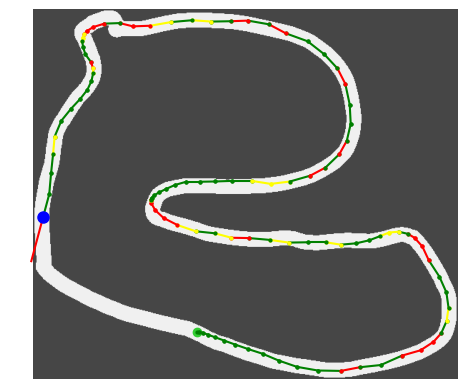

1.045358827416837


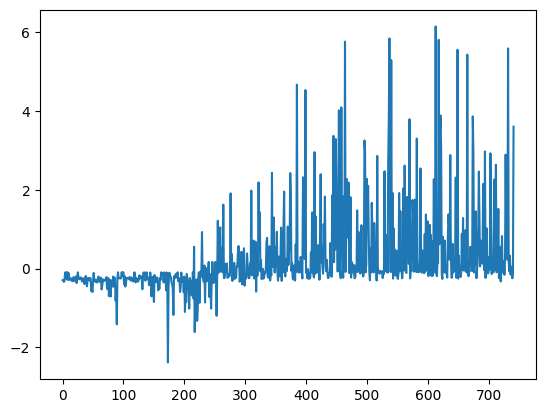

In [ ]:
env = Env()
env.track_for_training = len(TRACKS)
with open("../Return/Data/data QL/run_part1_2024-12-05_16:32:52/3600_40.json") as f :
    dic = json.load(f)
env.model.load("../Return/Data/data QL/"+dic["DQN_model_param"])
print(dic)
# playing(env)
# plt.plot(dic["reward_history"])
# print(dic["global_volatility"])

In [ ]:
print(j)